### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

import matplotlib.pyplot as plt
%matplotlib widget

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

### 0 - Setting the random state

In [96]:
random_state = min(332078,328202)

In [97]:
np.random.seed(random_state)

## 1 - Loading and Preparing the Data

### 1.1 - Import the dataset

In [ ]:
# Import csv
file_name = 'cla4lsp_customers.csv'
df_tot = pd.read_csv(file_name, sep='\t')

### 1.2 - Spit dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
workdf, not_workdf = train_test_split(df_tot, test_size = 1/3, random_state=random_state)

In [ ]:
# Save the dataframes
workdf.to_csv('working_dataset.csv')
not_workdf.to_csv('not_working_dataset.csv')

In [45]:
######
# Import the datasets
workdf = pd.read_csv('working_dataset.csv')
not_workdf = pd.read_csv('not_working_dataset.csv')
######

### 1.3 - Divide columns 

In [46]:
labels = ['NumDealsPurchases','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Complain','Recency']
features = ['Year_Birth','Education','Marital_Status','Income','Kidhome','Teenhome','Dt_Customer','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']
other_columns = [col for col in workdf.columns if col not in (labels + features)]

In [47]:
# Drop unknown columns
workdf = workdf.drop(other_columns, axis=1)

### 1.4 - Remove a random feature

In [48]:
purchasing_habits = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

In [49]:
# Removing random feature
random_pick = random.choice(purchasing_habits)
workdf = workdf.drop(random_pick, axis=1)
features.remove(random_pick)

### 1.5 - Data cleaning

In [50]:
print(f' NaN elements from working set:\n{workdf.isna().sum()}')
print(f' \nNaN elements from NON working set:\n{not_workdf.isna().sum()}')

 NaN elements from working set:
Year_Birth              0
Education               0
Marital_Status          0
Income                 16
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
dtype: int64
 
NaN elements from NON working set:
Unnamed: 0             0
ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 8
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines          

#### 1.5.1 - Drop columns

In [51]:
workdf.dropna(inplace=True)
not_workdf.dropna(inplace=True)

In [52]:
# Rows with NaN values
nan_mask = workdf['Income'].isna()
workdf[nan_mask]

Empty DataFrame
Columns: [Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Response]
Index: []

[0 rows x 25 columns]

In [53]:
# Group the incomes with respect to education level and marital status
grouped_df = workdf.groupby(['Education','Marital_Status'])['Income'].mean()

In [54]:
# Expected output
exp_out = []
for i in range(len(workdf[nan_mask])):
    exp_out.append(grouped_df[( workdf[nan_mask]['Education'].iloc[i] , workdf[nan_mask]['Marital_Status'].iloc[i] )])
exp_out

[]

In [55]:
# Extract row indices with NaN values
id = [workdf[nan_mask].index][0]

In [56]:
# Fill the NaN values
for i in workdf.index:
    if workdf['Income'].isna:
        workdf.loc[i,'Income'] = grouped_df[( workdf.loc[i,'Education'] , workdf.loc[i,'Marital_Status'] )]

In [57]:
# Check whether the newly substituted numbers are equal to the expected numbers
workdf.loc[id,'Income'] == exp_out

Series([], Name: Income, dtype: bool)

## 2 - Encoding of Categorical Data

In [58]:
# Encode the Education feature with one hot encoding 
workdf = pd.get_dummies(workdf, columns=['Education'])

In [59]:
# Encode the Marital_Status feature with one hot encoding 
workdf = pd.get_dummies(workdf, columns=['Marital_Status'])

In [60]:
workdf = workdf.replace({True: 1, False: 0})

##### Osservazioni
- dopo aver applicato get_dummies() la colonna marital_status è stata droppata
- è possibile verificare la riuscita del one hot encoding sfruttando .sum() e facendo riferimento alla cella con la funzione values_count()

In [61]:
# Drop Dt_Customer column
workdf = workdf.drop(columns='Dt_Customer')

In [62]:
# Update features list
features = [feature for feature in workdf.columns if feature not in labels]

In [63]:
workdf.describe()

Year_Birth        Income      Kidhome     Teenhome      Recency  \
count  1477.000000   1477.000000  1477.000000  1477.000000  1477.000000   
mean   1968.832769  52197.784699     0.452268     0.507109    48.810427   
std      12.167577   6134.053264     0.542181     0.541737    29.020119   
min    1893.000000   9548.000000     0.000000     0.000000     0.000000   
25%    1959.000000  50688.691030     0.000000     0.000000    24.000000   
50%    1970.000000  51967.087500     0.000000     0.000000    49.000000   
75%    1978.000000  56501.450000     1.000000     1.000000    73.000000   
max    1996.000000  79244.000000     2.000000     2.000000    99.000000   

          MntWines    MntFruits  MntMeatProducts  MntSweetProducts  \
count  1477.000000  1477.000000      1477.000000       1477.000000   
mean    302.437373    25.949221       169.330399         27.521327   
std     333.023270    39.419597       227.352628         41.503555   
min       0.000000     0.000000         1.000000          0.000000   
25%      24.000000     1.000000        16.000000          1.000000   
50%     179.000000     8.000000        68.000000          8.000000   
75%     493.000000    32.000000       238.000000         34.000000   
max    1492.000000   199.000000      1725.000000        262.000000   

       MntGoldProds  ...  Education_Master  Education_PhD  \
count   1477.000000  ...       1477.000000    1477.000000   
mean      42.989844  ...          0.153013       0.220041   
std       49.708124  ...          0.360122       0.414414   
min        0.000000  ...          0.000000       0.000000   
25%        9.000000  ...          0.000000       0.000000   
50%       25.000000  ...          0.000000       0.000000   
75%       54.000000  ...          0.000000       0.000000   
max      249.000000  ...          1.000000       1.000000   

       Marital_Status_Absurd  Marital_Status_Alone  Marital_Status_Divorced  \
count            1477.000000           1477.000000              1477.000000   
mean                0.001354              0.002031                 0.096818   
std                 0.036786              0.045038                 0.295810   
min                 0.000000              0.000000                 0.000000   
25%                 0.000000              0.000000                 0.000000   
50%                 0.000000              0.000000                 0.000000   
75%                 0.000000              0.000000                 0.000000   
max                 1.000000              1.000000                 1.000000   

       Marital_Status_Married  Marital_Status_Single  Marital_Status_Together  \
count             1477.000000            1477.000000              1477.000000   
mean                 0.383886               0.214624                 0.264049   
std                  0.486495               0.410700                 0.440975   
min                  0.000000               0.000000                 0.000000   
25%                  0.000000               0.000000                 0.000000   
50%                  0.000000               0.000000                 0.000000   
75%                  1.000000               0.000000                 1.000000   
max                  1.000000               1.000000                 1.000000   

       Marital_Status_Widow  Marital_Status_YOLO  
count           1477.000000          1477.000000  
mean               0.036561             0.000677  
std                0.187744             0.026020  
min                0.000000             0.000000  
25%                0.000000             0.000000  
50%                0.000000             0.000000  
75%                0.000000             0.000000  
max                1.000000             1.000000  

[8 rows x 35 columns]

From the description of the dataset, especially looking at the 75th percentile and the maximum value of the columns, we can see that the columns: 'Income' and 'Age' have some outliers.

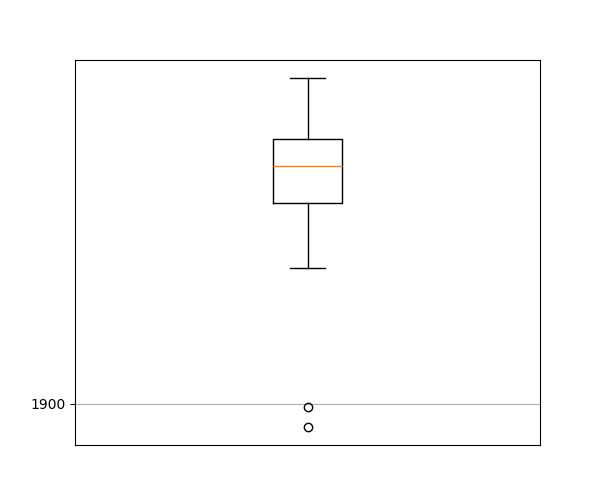

In [64]:
# Check the outlier from the 'Age' column
plt.figure(figsize=(6, 5))
plt.boxplot(workdf['Year_Birth'])
plt.yticks([1900])
plt.xticks([])
plt.grid()
plt.show()

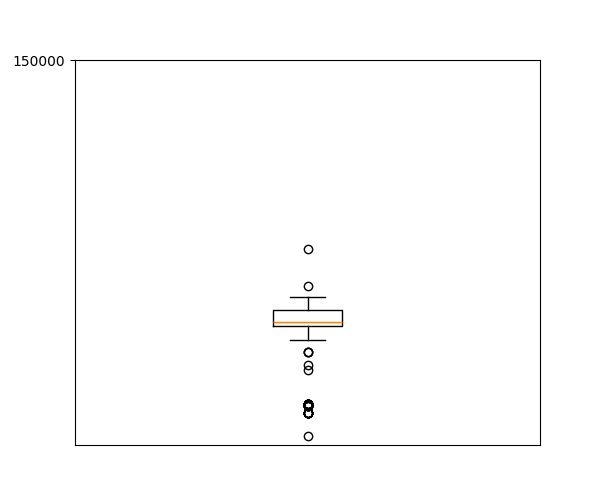

In [65]:
# Check the outlier from the 'Income' column
plt.figure(figsize=(6, 5))
plt.boxplot(workdf['Income'])
plt.yticks([150000])
plt.xticks([])
plt.grid()
plt.show()

In [66]:
# Exclude outlier
workdf = workdf[ (workdf['Income']<150000) ]
workdf = workdf[ (workdf['Year_Birth']>1900) ]

In [67]:
# Define sub-df by selecting feature columns
Xworkdf = workdf[features]

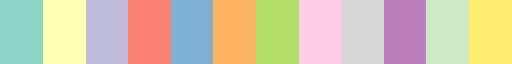

feature       category  \
0                Year_Birth  Personal_info   
1                    Income  Personal_info   
2                   Kidhome  Personal_info   
3                  Teenhome  Personal_info   
4                  MntWines         Amouts   
5                 MntFruits         Amouts   
6           MntMeatProducts         Amouts   
7          MntSweetProducts         Amouts   
8              MntGoldProds         Amouts   
9           NumWebPurchases        Numbers   
10      NumCatalogPurchases        Numbers   
11        NumStorePurchases        Numbers   
12        NumWebVisitsMonth        Numbers   
13       Education_2n Cycle  Personal_info   
14          Education_Basic  Personal_info   
15     Education_Graduation  Personal_info   
16         Education_Master  Personal_info   
17            Education_PhD  Personal_info   
18    Marital_Status_Absurd  Personal_info   
19     Marital_Status_Alone  Personal_info   
20  Marital_Status_Divorced  Personal_info   
21   Marital_Status_Married  Personal_info   
22    Marital_Status_Single  Personal_info   
23  Marital_Status_Together  Personal_info   
24     Marital_Status_Widow  Personal_info   
25      Marital_Status_YOLO  Personal_info   

                                                color  
0   (0.5529411764705883, 0.8274509803921568, 0.780...  
1   (0.5529411764705883, 0.8274509803921568, 0.780...  
2   (0.5529411764705883, 0.8274509803921568, 0.780...  
3   (0.5529411764705883, 0.8274509803921568, 0.780...  
4                      (1.0, 1.0, 0.7019607843137254)  
5                      (1.0, 1.0, 0.7019607843137254)  
6                      (1.0, 1.0, 0.7019607843137254)  
7                      (1.0, 1.0, 0.7019607843137254)  
8                      (1.0, 1.0, 0.7019607843137254)  
9   (0.7450980392156863, 0.7294117647058823, 0.854...  
10  (0.7450980392156863, 0.7294117647058823, 0.854...  
11  (0.7450980392156863, 0.7294117647058823, 0.854...  
12  (0.7450980392156863, 0.7294117647058823, 0.854...  
13  (0.5529411764705883, 0.8274509803921568, 0.780...  
14  (0.5529411764705883, 0.8274509803921568, 0.780...  
15  (0.5529411764705883, 0.8274509803921568, 0.780...  
16  (0.5529411764705883, 0.8274509803921568, 0.780...  
17  (0.5529411764705883, 0.8274509803921568, 0.780...  
18  (0.5529411764705883, 0.8274509803921568, 0.780...  
19  (0.5529411764705883, 0.8274509803921568, 0.780...  
20  (0.5529411764705883, 0.8274509803921568, 0.780...  
21  (0.5529411764705883, 0.8274509803921568, 0.780...  
22  (0.5529411764705883, 0.8274509803921568, 0.780...  
23  (0.5529411764705883, 0.8274509803921568, 0.780...  
24  (0.5529411764705883, 0.8274509803921568, 0.780...  
25  (0.5529411764705883, 0.8274509803921568, 0.780...

In [82]:
# Set the color for different categories of features

# dataframe with these columns [features, category, color]
set3 = cm.Set3.colors

######### SHOWING THE COLORS OF THE CHOSEN COLORMAP #########
display(cm.Set3)
#############################################################

data = {'feature': Xworkdf.columns}
feature_cat_df = pd.DataFrame(data)

cat_dict = { 'Year_Birth': 'Personal_info', 
            'Income': 'Personal_info', 
            'Kidhome': 'Personal_info', 
            'Teenhome': 'Personal_info', 
            'MntWines': 'Amouts', 
            'MntFruits': 'Amouts',
            'MntMeatProducts': 'Amouts', 
            'MntFishProducts': 'Amouts', 
            'MntSweetProducts': 'Amouts',
            'MntGoldProds': 'Amouts', 
            'NumWebPurchases': 'Numbers', 
            'NumCatalogPurchases': 'Numbers',
            'NumStorePurchases':'Numbers',
            'NumWebVisitsMonth': 'Numbers', 
            'Education_2n Cycle': 'Personal_info', 
            'Education_Basic': 'Personal_info',
            'Education_Graduation': 'Personal_info', 
            'Education_Master': 'Personal_info', 
            'Education_PhD': 'Personal_info',
            'Marital_Status_Absurd': 'Personal_info',
            'Marital_Status_Alone': 'Personal_info',
            'Marital_Status_Divorced': 'Personal_info', 
            'Marital_Status_Married': 'Personal_info',
            'Marital_Status_Single': 'Personal_info', 
            'Marital_Status_Together': 'Personal_info',
            'Marital_Status_Widow': 'Personal_info', 
            'Marital_Status_YOLO': 'Personal_info'
}

feature_cat_df['category'] = pd.Series([cat_dict[t] for t in feature_cat_df['feature']])

cat_colors = {
    'Personal_info': set3[0],
    'Amouts': set3[1],
    'Numbers': set3[2],
}

feature_cat_df['color'] = feature_cat_df['category'].map(cat_colors)

display(feature_cat_df)

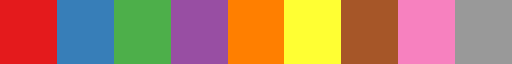

AcceptedCmp                                              color
0            Other  (0.8941176470588236, 0.10196078431372549, 0.10...
1            Other  (0.8941176470588236, 0.10196078431372549, 0.10...
2     AcceptedCmp1  (0.21568627450980393, 0.49411764705882355, 0.7...
3            Other  (0.8941176470588236, 0.10196078431372549, 0.10...
4            Other  (0.8941176470588236, 0.10196078431372549, 0.10...
...            ...                                                ...
1488         Other  (0.8941176470588236, 0.10196078431372549, 0.10...
1489  AcceptedCmp5                     (1.0, 0.4980392156862745, 0.0)
1490         Other  (0.8941176470588236, 0.10196078431372549, 0.10...
1491         Other  (0.8941176470588236, 0.10196078431372549, 0.10...
1492         Other  (0.8941176470588236, 0.10196078431372549, 0.10...

[1475 rows x 2 columns]

In [80]:
# Set the color for different person wrt AcceptedCmp labels

set1 = cm.Set1.colors

######### SHOWING THE COLORS OF THE CHOSEN COLORMAP #########
display(cm.Set1)
#############################################################

# label of interest
interesting_labels = [col for col in workdf.columns if col.startswith('AcceptedCmp')]

# 
label_df = workdf[sorted(interesting_labels)].copy()

def find_feature_name(row):
    for col in label_df.columns:
        if row[col] == 1:
            return col
    return 'Other'

label_df['AcceptedCmp'] = label_df.apply(find_feature_name, axis=1)

label_df = label_df.drop(columns=interesting_labels)

label_dict = {'Other': set1[0],
            'AcceptedCmp1': set1[1] ,
            'AcceptedCmp3': set1[2],
            'AcceptedCmp4': set1[3],
            'AcceptedCmp5': set1[4],
            'AcceptedCmp2': set1[5],
}

label_df['color'] = label_df['AcceptedCmp'].map(label_dict)

label_df

## 3 - Preprocessing and full-PCA

### 3.1 - Standardize the features

In [83]:
# Create Xworkdf_std using the Standard scaler
Xworkdf_std = StandardScaler()
#fit
Xworkdf_std.fit(Xworkdf.values)
#transform
t_Xworkdf_std = Xworkdf_std.transform(Xworkdf.values)

# Create Xworksf_mm using the MinMax scaler
Xworksf_mm = MinMaxScaler()
#fit
Xworksf_mm.fit(Xworkdf.values)
#transform
t_Xworksf_mm = Xworksf_mm.transform(Xworkdf.values)

### 3.2 - First look at the variances (TODO)

### 3.3 - Full PCA

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


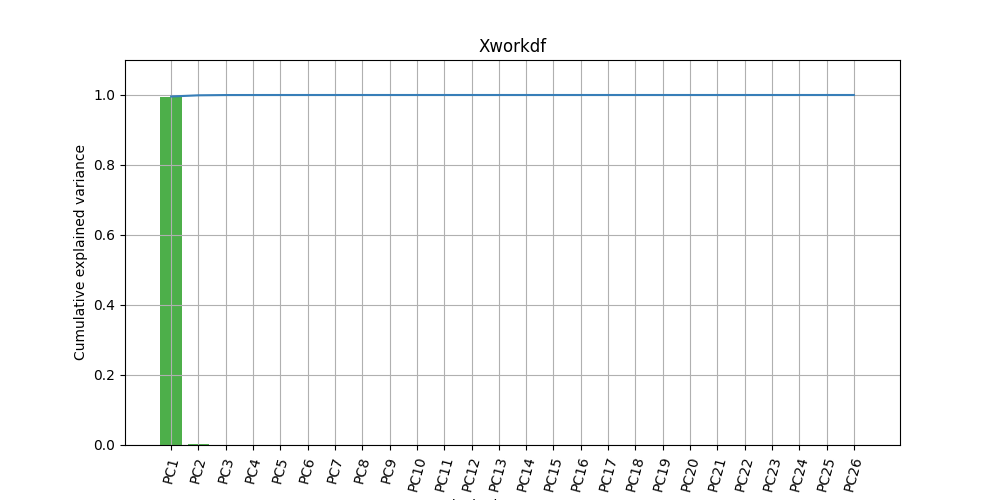

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


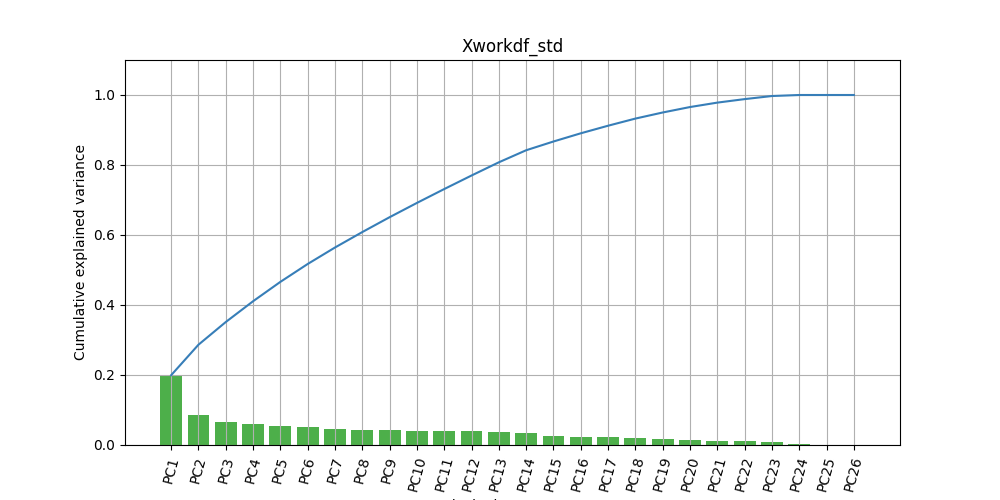

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


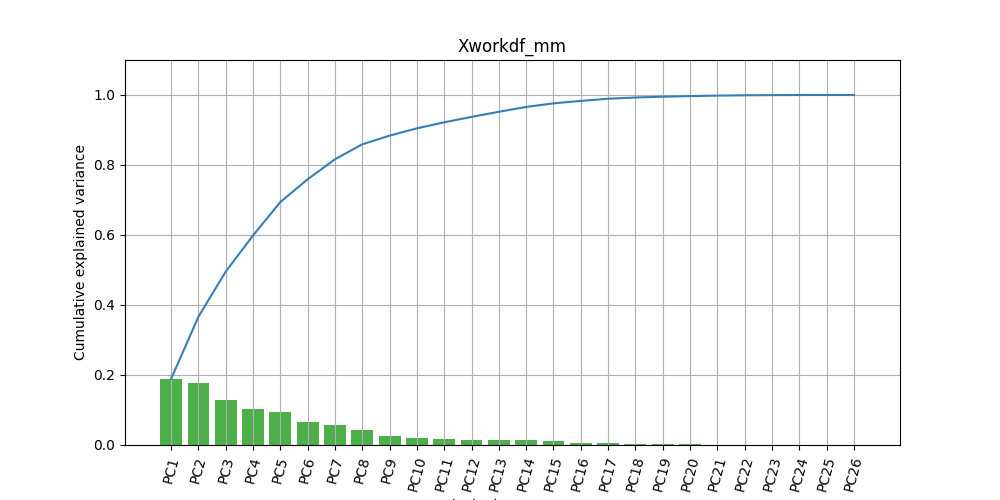

In [84]:
#Apply the “full” PCA1 to the DFs Xworkdf, Xworkdf_std, and Xworkdf_mm
pca_Xworkdf = PCA()
pca_Xworkdf_std = PCA()
pca_Xworkdf_mm = PCA()

pca_Xworkdf.fit(Xworkdf[features].values) 
pca_Xworkdf_std.fit(t_Xworkdf_std)
pca_Xworkdf_mm.fit(t_Xworksf_mm)

# color set
set1 = cm.Set1.colors


#plot the curve of the cumulative explained variance
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_Xworkdf.explained_variance_ratio_), c=set1[1])
plt.bar(height = pca_Xworkdf.explained_variance_ratio_, x = np.arange(26), color=set1[2])
plt.title('Xworkdf')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_Xworkdf.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_Xworkdf.n_features_)],
           rotation = 75)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_Xworkdf_std.explained_variance_ratio_), c=set1[1])
plt.bar(height = pca_Xworkdf_std.explained_variance_ratio_, x = np.arange(26), color=set1[2])
plt.title('Xworkdf_std')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_Xworkdf_std.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_Xworkdf_std.n_features_)],
           rotation = 75)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_Xworkdf_mm.explained_variance_ratio_), c=set1[1])
plt.bar(height = pca_Xworkdf_mm.explained_variance_ratio_, x = np.arange(26), color=set1[2])
plt.title('Xworkdf_mm')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_Xworkdf_mm.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_Xworkdf_mm.n_features_)],
           rotation = 75)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

## 4 - Dimensionality Reduction and Interpretation of the PCs

### 4.1 - Selection and display of PCs

In [85]:
m_star_std = 3 # m' of Xworkdf_std
m_star_mm = 2 # m' of Xworkdf_mm

m_std = min(m_star_std,5)
m_mm = min(m_star_mm,5)

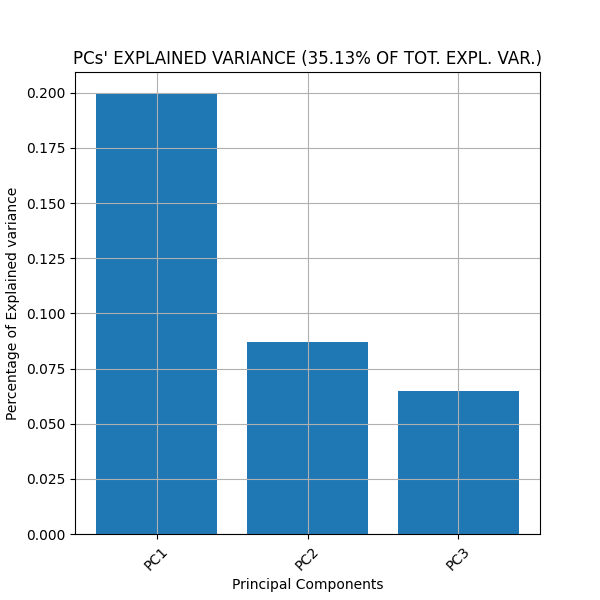

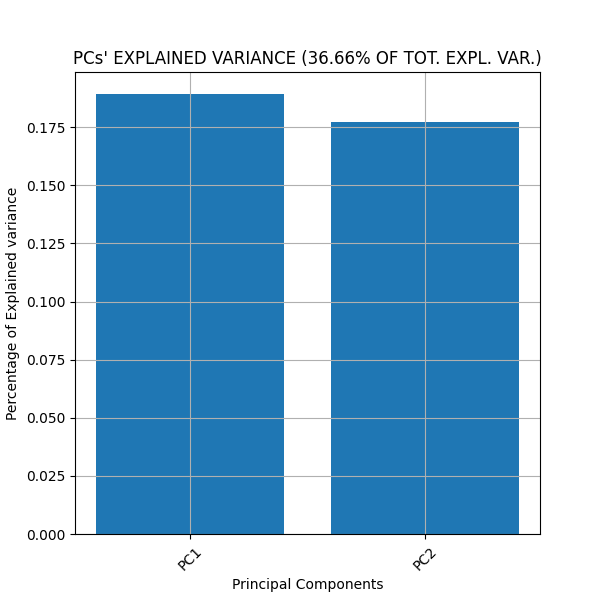

In [86]:
# PCA
pca_std = PCA(n_components = m_std)
pca_mm = PCA(n_components = m_mm)

# Fit the PCA of StandarScaler data
pca_std.fit(t_Xworkdf_std)

# Explained variance rounded to 2 decimals
round_expl_var_ratio_std = np.round(pca_std.explained_variance_ratio_.sum()*100,2)

# Barplots
plt.figure(figsize=(6, 6))
plt.bar(range(1,m_std+1), pca_std.explained_variance_ratio_)
plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_std}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1,m_std+1), 
           labels=[f'PC{i}' for i in range(1,m_std+1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

# Fit the PCA of MinMaxScaler data
pca_mm.fit(t_Xworksf_mm)

# Explained variance rounded to 2 decimals
round_expl_var_ratio_mm = np.round(pca_mm.explained_variance_ratio_.sum()*100,2)

# Barplots
plt.figure(figsize=(6, 6))
plt.bar(range(1,m_mm+1), pca_mm.explained_variance_ratio_)
plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_mm}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1,m_mm+1), 
           labels=[f'PC{i}' for i in range(1,m_mm+1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

### 4.2 - Interpretation of the PCs

#### 4.2.1 - Interpretation of the PCs for StandardScaler data

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


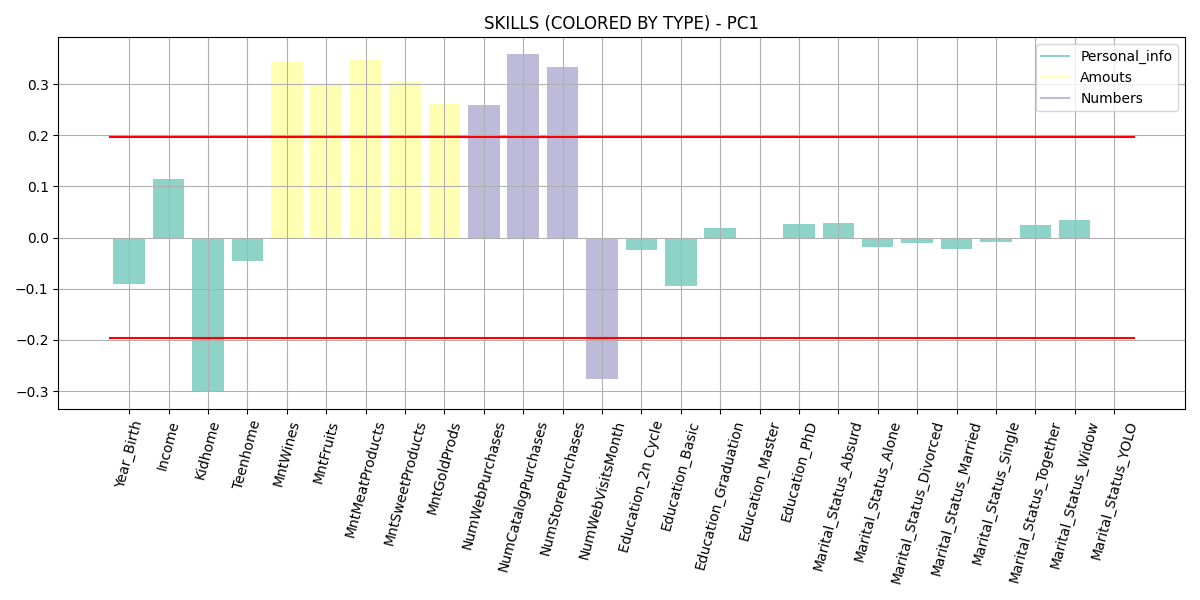

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)



****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

HIGH-VALUED NEGATIVE COMPONENTS: ['Kidhome', 'NumWebVisitsMonth']
*********************************************



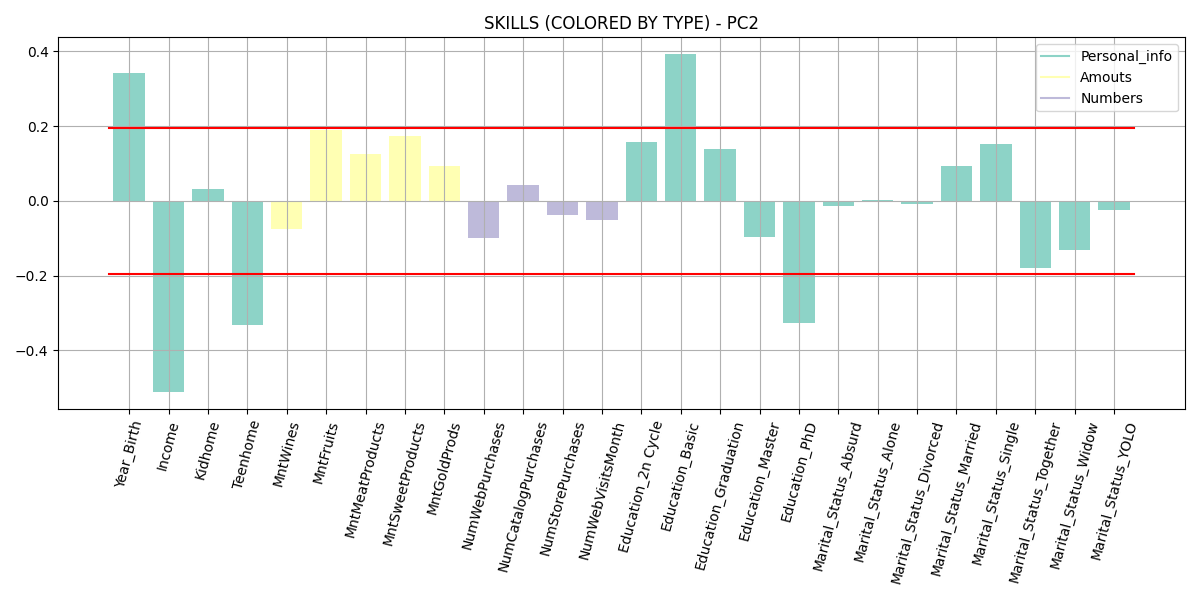


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Year_Birth', 'Education_Basic']

HIGH-VALUED NEGATIVE COMPONENTS: ['Income', 'Teenhome', 'Education_PhD']
*********************************************



/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


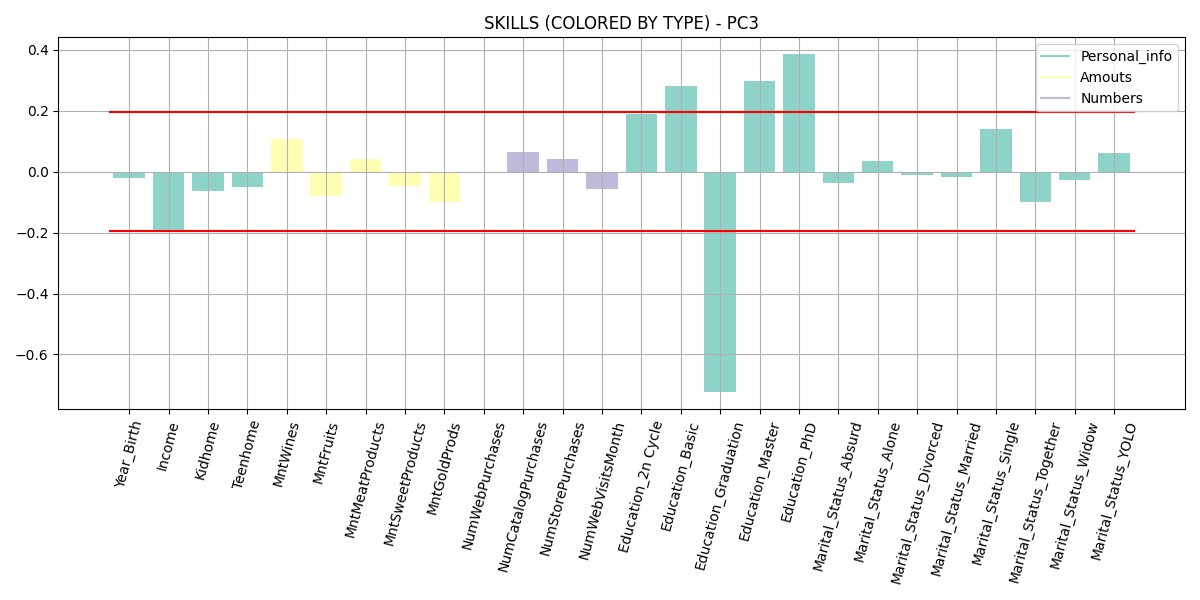


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Education_Basic', 'Education_Master', 'Education_PhD']

HIGH-VALUED NEGATIVE COMPONENTS: ['Education_Graduation']
*********************************************



In [87]:
from matplotlib.lines import Line2D
# DEFINE EPSILON
eps = np.sqrt(1 / pca_std.n_features_)

# DEFINE THE LIST OF SKILL COLORS W.R.T. THE SKILL TYPES AND THE SKILL CATEGORIES
cat_color = [feature_cat_df.loc[feature_cat_df['category'] == s]['color'].values[0] for s in feature_cat_df['category']]

# MAKE A CUSTOM LEGEND
cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]

# FOR-CYCLE TO GENERALIZE THE PLOT COMMANDS
for ii in range(m_std):
    # MAKE THE BARPLOT WITH SKILL TYPE COLORS
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(pca_std.n_features_), pca_std.components_[ii, :], color= cat_color)
    
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_std.n_features_),
               labels= features,
               rotation=75)
    plt.title(f'SKILLS (COLORED BY TYPE) - PC{ii + 1}')
    plt.legend(cat_colors_legend, [k for k in cat_colors.keys()])
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # THE SELECTION OF THE SKILLS WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii = np.argwhere(pca_std.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_std.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [features[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

In [88]:
pc_names_std = ['Kids & Web Activity (-) VS High Spending (+)',
                'Youth & Graduation Education (-) VS Adolescent Presence & PhD Education (+)',
                'Teens & Graduation Education (-) VS Young & Higher Education (+)'
               ]

#### 4.2.1 - Interpretation of the PCs for MinMaxScaler data

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


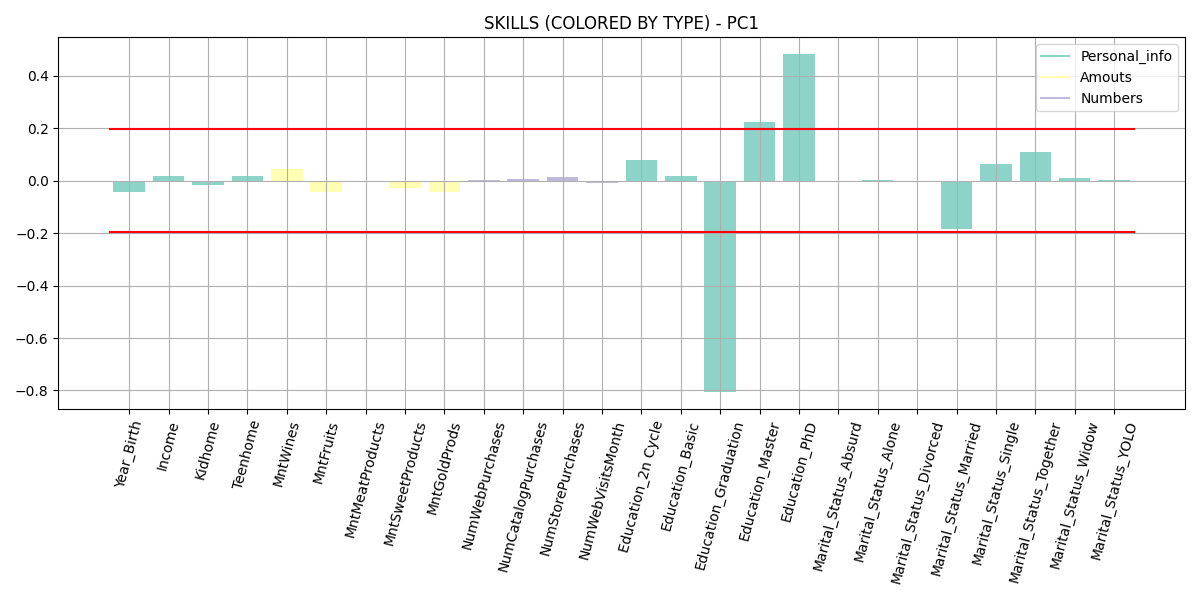

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)



****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Education_Master', 'Education_PhD']

HIGH-VALUED NEGATIVE COMPONENTS: ['Education_Graduation']
*********************************************



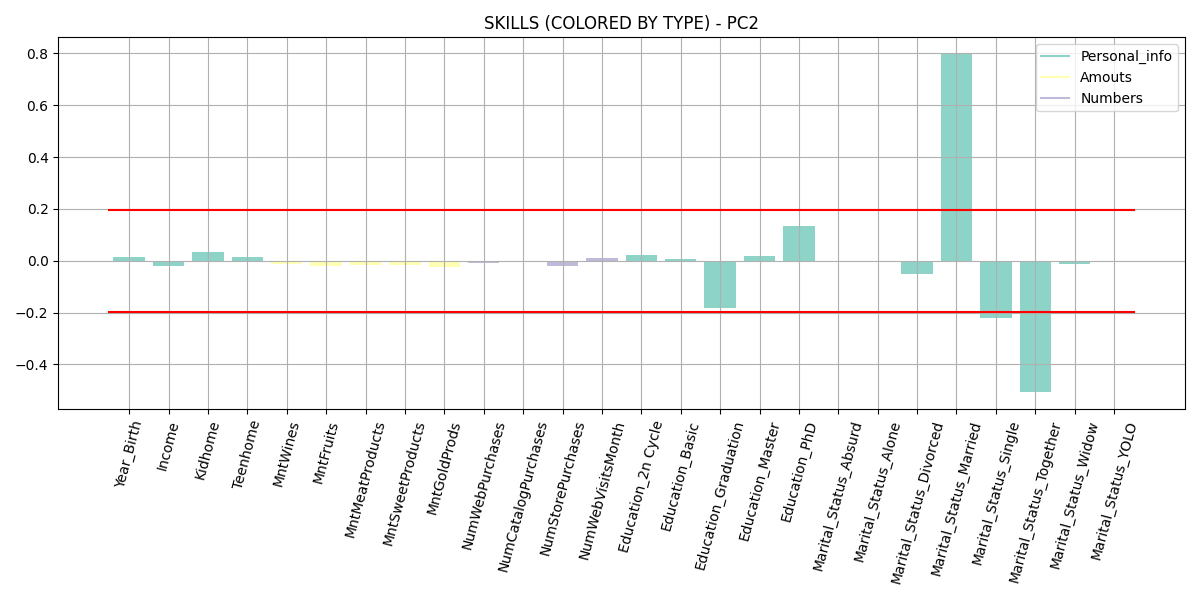


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Marital_Status_Married']

HIGH-VALUED NEGATIVE COMPONENTS: ['Marital_Status_Single', 'Marital_Status_Together']
*********************************************



In [89]:
# DEFINE EPSILON
eps = np.sqrt(1 / pca_mm.n_features_)

# DEFINE THE LIST OF SKILL COLORS W.R.T. THE SKILL TYPES AND THE SKILL CATEGORIES
cat_color = [feature_cat_df.loc[feature_cat_df['category'] == s]['color'].values[0] for s in feature_cat_df['category']]

# MAKE A CUSTOM LEGEND
cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]

# FOR-CYCLE TO GENERALIZE THE PLOT COMMANDS
for ii in range(m_mm):
    # MAKE THE BARPLOT WITH SKILL TYPE COLORS
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(pca_mm.n_features_), pca_mm.components_[ii, :], color=cat_color)
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_mm.n_features_),
               labels= features,
               rotation=75)
    plt.title(f'SKILLS (COLORED BY TYPE) - PC{ii + 1}')
    plt.legend(cat_colors_legend, [k for k in cat_colors.keys()])
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # THE SELECTION OF THE SKILLS WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii = np.argwhere(pca_mm.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_mm.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [features[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

In [90]:
pc_names_mm = ['Graduation (-) VS Master & PhD (+)',
               'Single & Together (-) VS Married(+)']

### 4.3 - Score graphs

#### 4.3.1 - Score graph for StandardScaler data

In [ ]:
pd.DataFrame(Yworkdf_std).

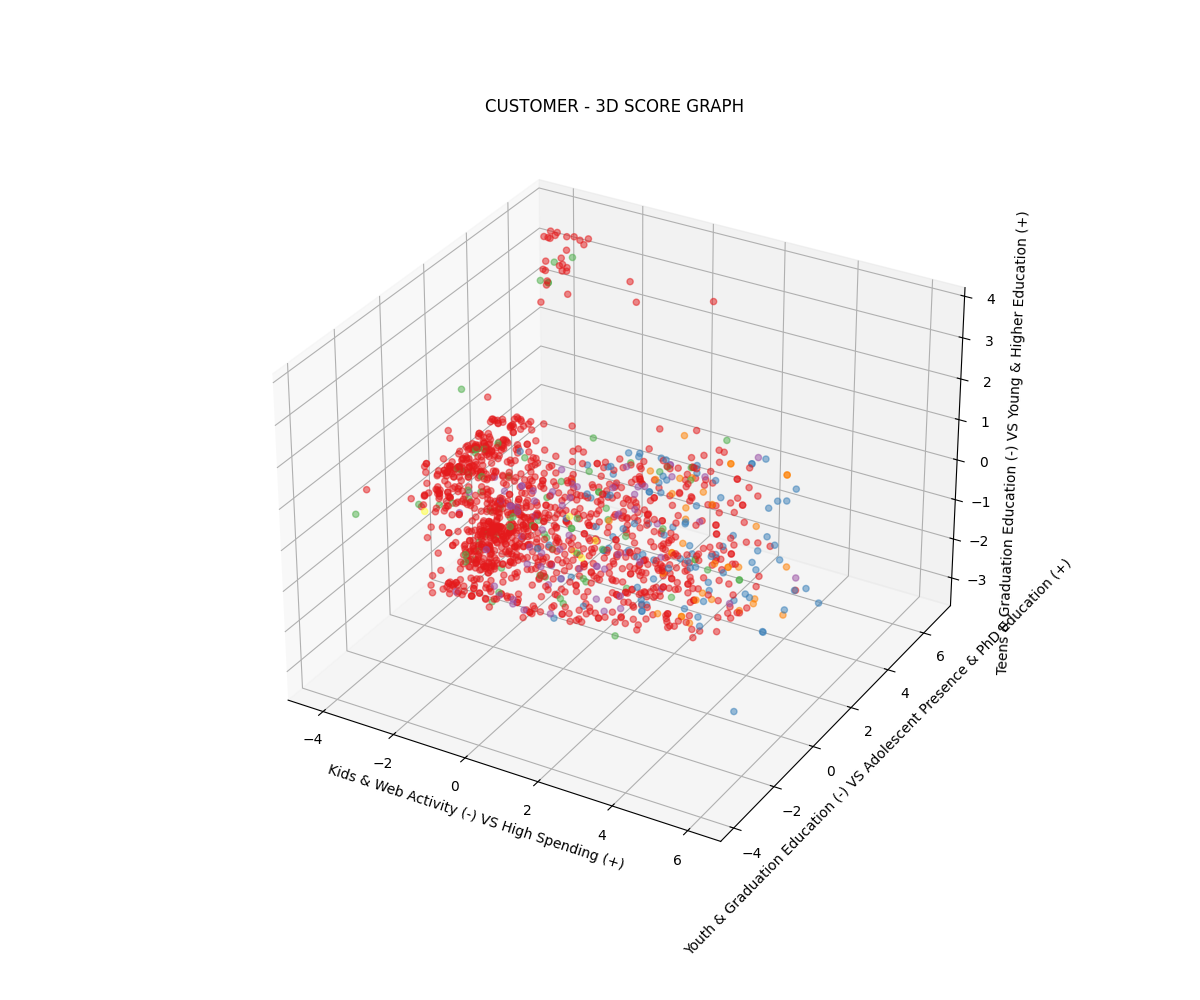

In [92]:
# PCA transform 
Yworkdf_std = pca_std.transform(t_Xworkdf_std)

# 3D Score graph
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1], Yworkdf_std[:, 2], c=label_df['color'].values, alpha=0.5)

ax.set_xlabel(pc_names_std[0])
ax.set_ylabel(pc_names_std[1])
ax.set_zlabel(pc_names_std[2])

plt.title('CUSTOMER - 3D SCORE GRAPH')
plt.grid()
plt.show()

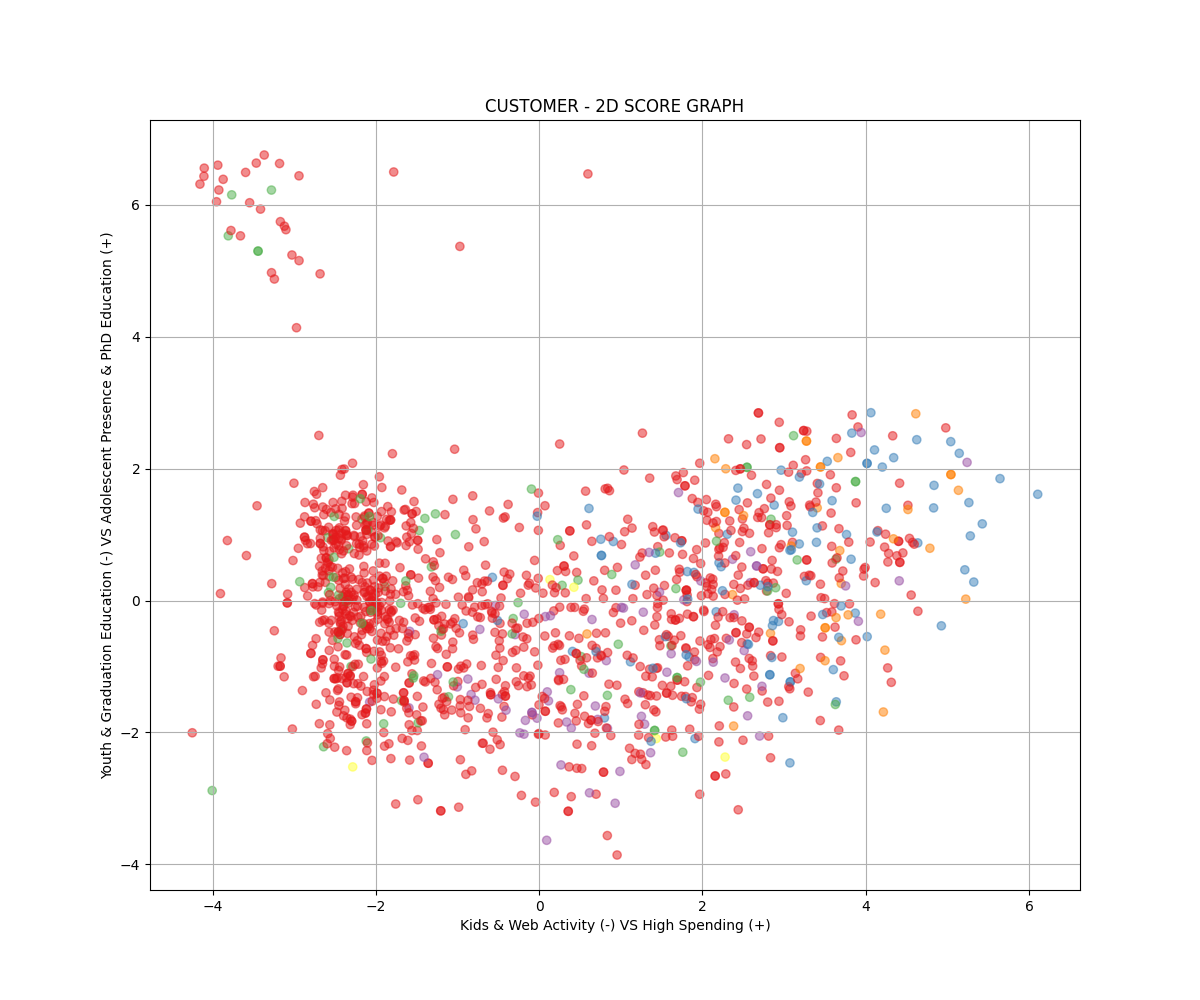

In [93]:
# 2D Score graph
sg = plt.figure(figsize=(12, 10))
as_sg = sg.add_subplot(111)

as_sg.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1], c=label_df['color'].values, alpha=0.5)

as_sg.set_xlabel(pc_names_std[0])
as_sg.set_ylabel(pc_names_std[1])
plt.title('CUSTOMER - 2D SCORE GRAPH')
plt.grid()
plt.show()


#### 4.3.2 - Score graph for MinMaxScaler data

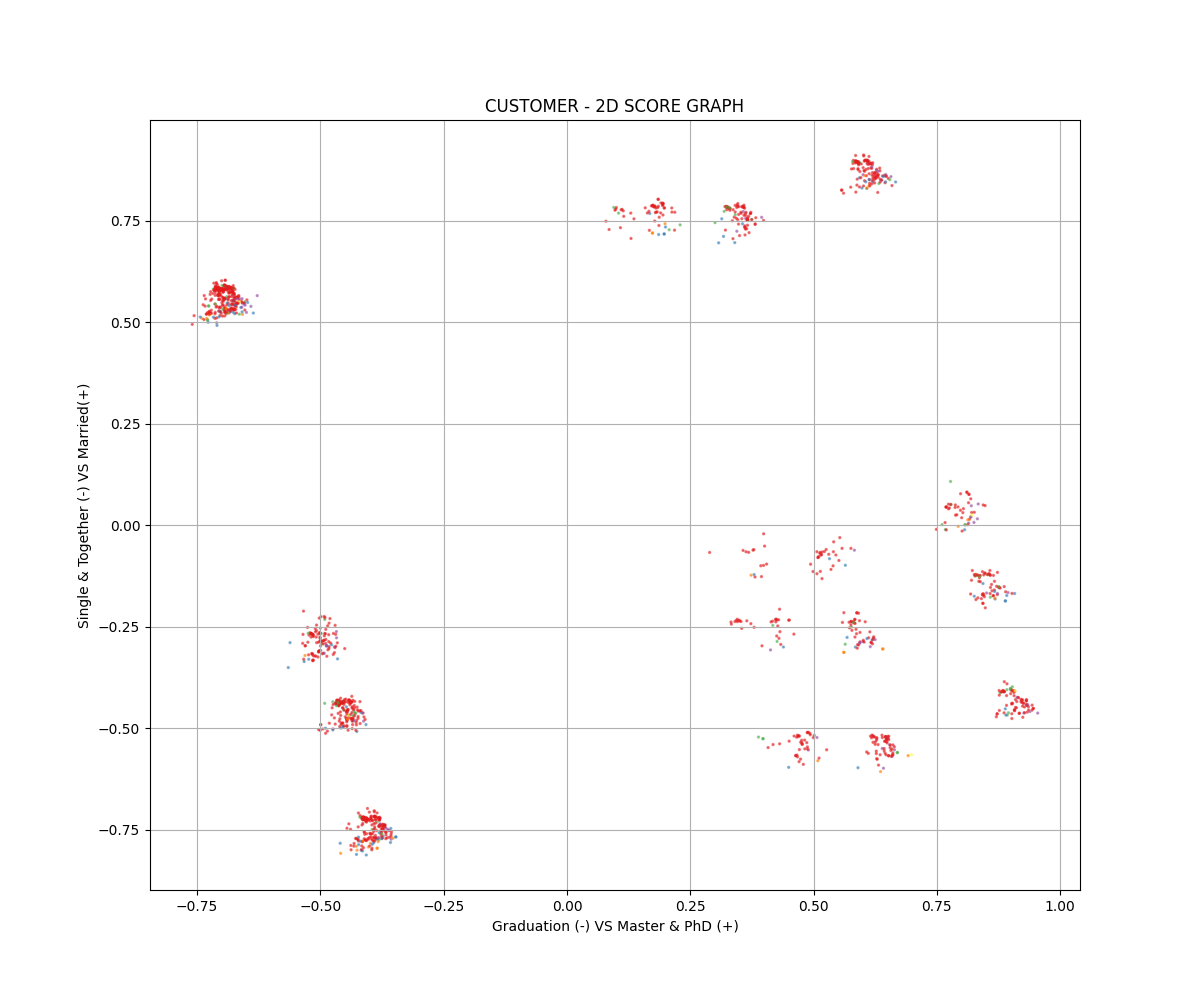

In [94]:
# PCA transform
Yworkdf_mm = pca_mm.transform(t_Xworksf_mm)

# 2D Score graph
sg = plt.figure(figsize=(12, 10))
as_sg = sg.add_subplot(111)

as_sg.scatter(Yworkdf_mm[:, 0], Yworkdf_mm[:, 1], s=2, c=label_df['color'].values, alpha=0.5)

as_sg.set_xlabel(pc_names_mm[0])
as_sg.set_ylabel(pc_names_mm[1])
plt.title('CUSTOMER - 2D SCORE GRAPH')
plt.grid()
plt.show()


### 4.4 - More accurate score graphs

### 4.5 - Analysis and comment

## 5 - K-Means

In [98]:
km_list_std = []
silcoeff_list_std = []
k_list_std = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list_std)):
    print(f'****************** START k-MEANS WITH k={k_list_std[i]} ******************')
    print('Computing...')
    km_list_std.append(KMeans(n_clusters=k_list_std[i], n_init=3, random_state=random_state))
    km_std = km_list_std[i]
    km_std.fit(Yworkdf_std)
    silcoeff_list_std.append(silhouette_score(Yworkdf_std,km_std.labels_))
    print(f'****************** END k-MEANS WITH k={k_list_std[i]} ******************')
    print('\n')
    

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_std = np.argmax(silcoeff_list_std)
k_std = k_list_std[i_best_std]
km_std = km_list_std[i_best_std]

# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list_std)} --> k = {k_std}') 
print('**************************************************************')

****************** START k-MEANS WITH k=3 ******************
Computing...
****************** END k-MEANS WITH k=3 ******************


****************** START k-MEANS WITH k=4 ******************
Computing...
****************** END k-MEANS WITH k=4 ******************


****************** START k-MEANS WITH k=5 ******************
Computing...
****************** END k-MEANS WITH k=5 ******************


****************** START k-MEANS WITH k=6 ******************
Computing...
****************** END k-MEANS WITH k=6 ******************


****************** START k-MEANS WITH k=7 ******************
Computing...
****************** END k-MEANS WITH k=7 ******************


****************** START k-MEANS WITH k=8 ******************
Computing...
****************** END k-MEANS WITH k=8 ******************


****************** START k-MEANS WITH k=9 ******************
Computing...
****************** END k-MEANS WITH k=9 ******************


****************** START k-MEANS WITH k=10 ************

In [99]:
km_list_mm = []
silcoeff_list_mm = []
k_list_mm = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list_mm)):
    print(f'****************** START k-MEANS WITH k={k_list_mm[i]} ******************')
    print('Computing...')
    km_list_mm.append(KMeans(n_clusters=k_list_mm[i], n_init=3, random_state=random_state))
    km_mm = km_list_mm[i]
    km_mm.fit(Yworkdf_mm)
    silcoeff_list_mm.append(silhouette_score(Yworkdf_mm,km_mm.labels_))
    print(f'****************** END k-MEANS WITH k={k_list_mm[i]} ******************')
    print('\n')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_mm = np.argmax(silcoeff_list_mm)
k_mm = k_list_mm[i_best_std]
km_mm = km_list_mm[i_best_std]

# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list_mm)} --> k = {k_mm}') 
print('**************************************************************')

****************** START k-MEANS WITH k=3 ******************
Computing...
****************** END k-MEANS WITH k=3 ******************


****************** START k-MEANS WITH k=4 ******************
Computing...
****************** END k-MEANS WITH k=4 ******************


****************** START k-MEANS WITH k=5 ******************
Computing...
****************** END k-MEANS WITH k=5 ******************


****************** START k-MEANS WITH k=6 ******************
Computing...
****************** END k-MEANS WITH k=6 ******************


****************** START k-MEANS WITH k=7 ******************
Computing...
****************** END k-MEANS WITH k=7 ******************


****************** START k-MEANS WITH k=8 ******************
Computing...
****************** END k-MEANS WITH k=8 ******************


****************** START k-MEANS WITH k=9 ******************
Computing...
****************** END k-MEANS WITH k=9 ******************


****************** START k-MEANS WITH k=10 ************

## 6 - Clusters and Centroid Interpretation and Visualization

/var/folders/6f/kjvx9lts3sz3x29562mtdxdw0000gn/T/ipykernel_12206/2624572328.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  sg_km = plt.figure(figsize=(8, 8))


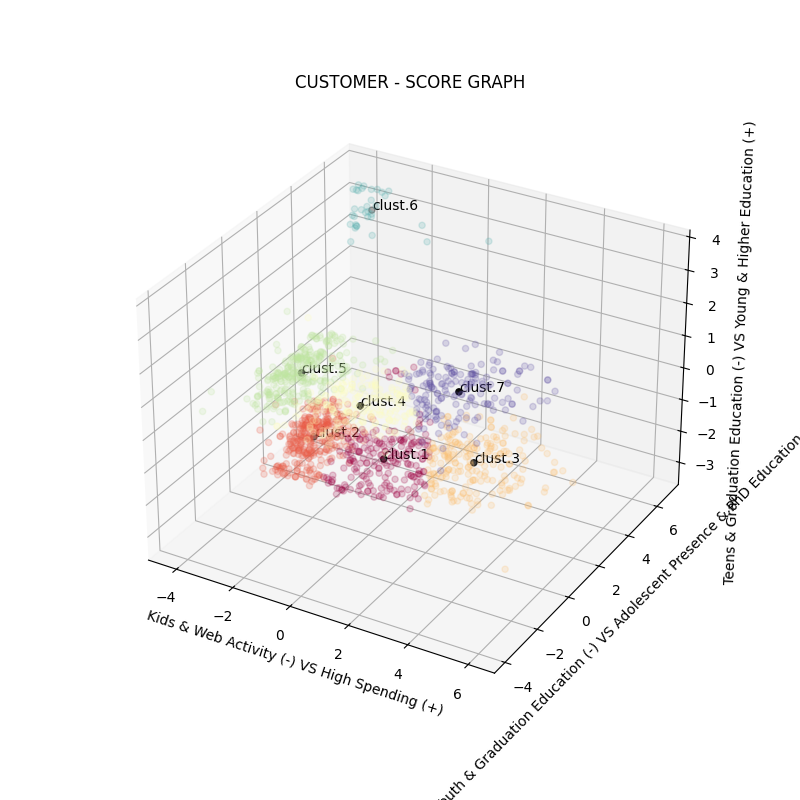

In [100]:
# Score graph with centroids for MinMaxScaler data
labels_std = km_std.labels_

sg_km = plt.figure(figsize=(8, 8))
ax_sg_km = sg_km.add_subplot(111, projection='3d')

ax_sg_km.scatter(Yworkdf_std[:, 0], 
                 Yworkdf_std[:, 1], 
                 Yworkdf_std[:, 2],
                 s=20,
                 c=labels_std, 
                 cmap='Spectral', 
                 alpha=0.2)

ax_sg_km.scatter(km_std.cluster_centers_[:, 0], 
                 km_std.cluster_centers_[:, 1],
                 km_std.cluster_centers_[:, 2],  # Corrected this line
                 c='black')

for kk in range(k_std):
    ax_sg_km.text(km_std.cluster_centers_[kk, 0], 
                  km_std.cluster_centers_[kk, 1], 
                  km_std.cluster_centers_[kk, 2],  # Corrected this line
                  f'clust.{kk+1}')

plt.title('CUSTOMER - SCORE GRAPH')
ax_sg_km.set_xlabel(pc_names_std[0])
ax_sg_km.set_ylabel(pc_names_std[1])
ax_sg_km.set_zlabel(pc_names_std[2])  # Added this line
plt.grid()
plt.show()


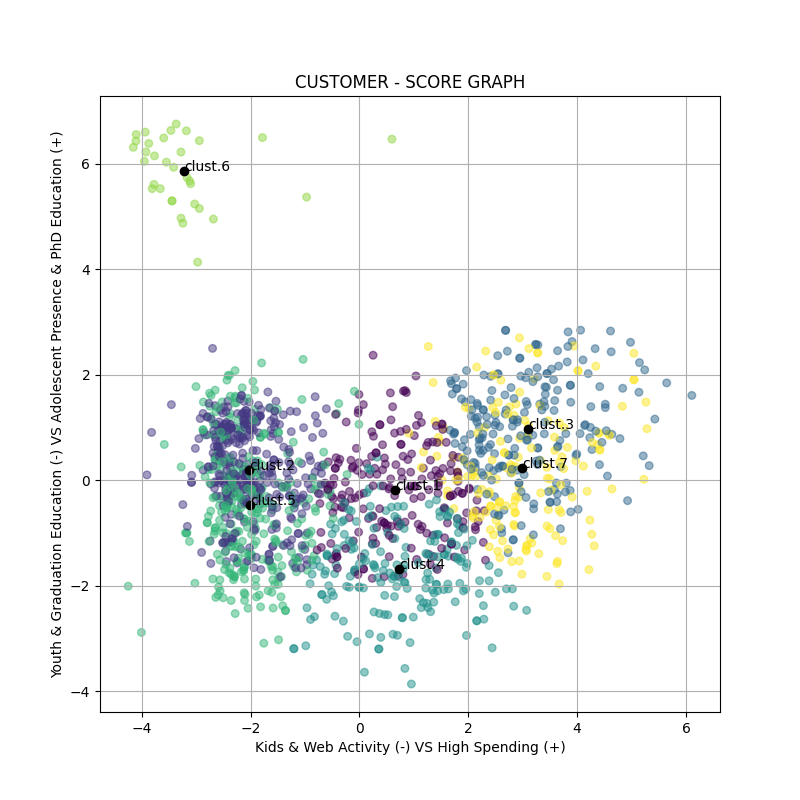

In [101]:
# Score graph with centroids for MinMaxScaler data
labels_std = km_std.labels_

sg_km = plt.figure(figsize=(8, 8))
ax_sg_km = sg_km.add_subplot(111)
ax_sg_km.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1],s=30,c=labels_std, cmap='viridis', alpha=0.5)
ax_sg_km.scatter(km_std.cluster_centers_[:,0], km_std.cluster_centers_[:,1], c='black')
for kk in range(k_std):
    ax_sg_km.text(km_std.cluster_centers_[kk, 0], km_std.cluster_centers_[kk, 1], f'clust.{kk+1}')
plt.title('CUSTOMER - SCORE GRAPH')
ax_sg_km.set_xlabel(pc_names_std[0])
ax_sg_km.set_ylabel(pc_names_std[1])
#plt.legend(genpos_colors_legend, [k for k in genpos_colors.keys()])
plt.grid()
plt.show()

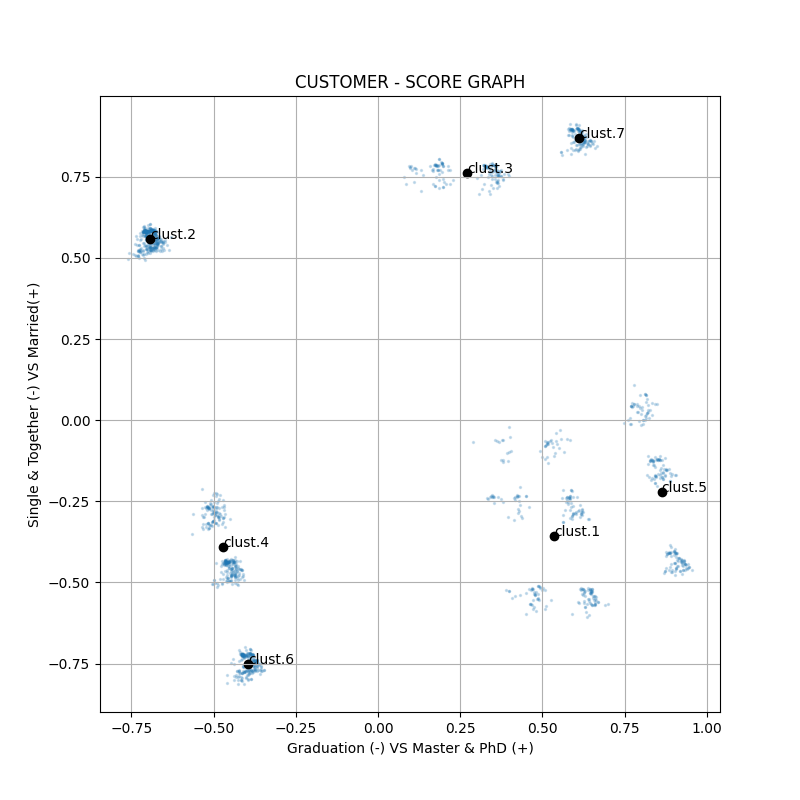

In [104]:
# Score graph with centroids for MinMaxScaler data
sg_km = plt.figure(figsize=(8, 8))
ax_sg_km = sg_km.add_subplot(111)
ax_sg_km.scatter(Yworkdf_mm[:, 0], Yworkdf_mm[:, 1], s=2,alpha=0.2)
ax_sg_km.scatter(km_mm.cluster_centers_[:,0], km_mm.cluster_centers_[:,1], c='black')
for kk in range(k_mm):
    ax_sg_km.text(km_mm.cluster_centers_[kk, 0], km_mm.cluster_centers_[kk, 1], f'clust.{kk+1}')
plt.title('CUSTOMER - SCORE GRAPH')
ax_sg_km.set_xlabel(pc_names_mm[0])
ax_sg_km.set_ylabel(pc_names_mm[1])
#plt.legend(genpos_colors_legend, [k for k in genpos_colors.keys()])
plt.grid()
plt.show()

In [107]:
k_std

7

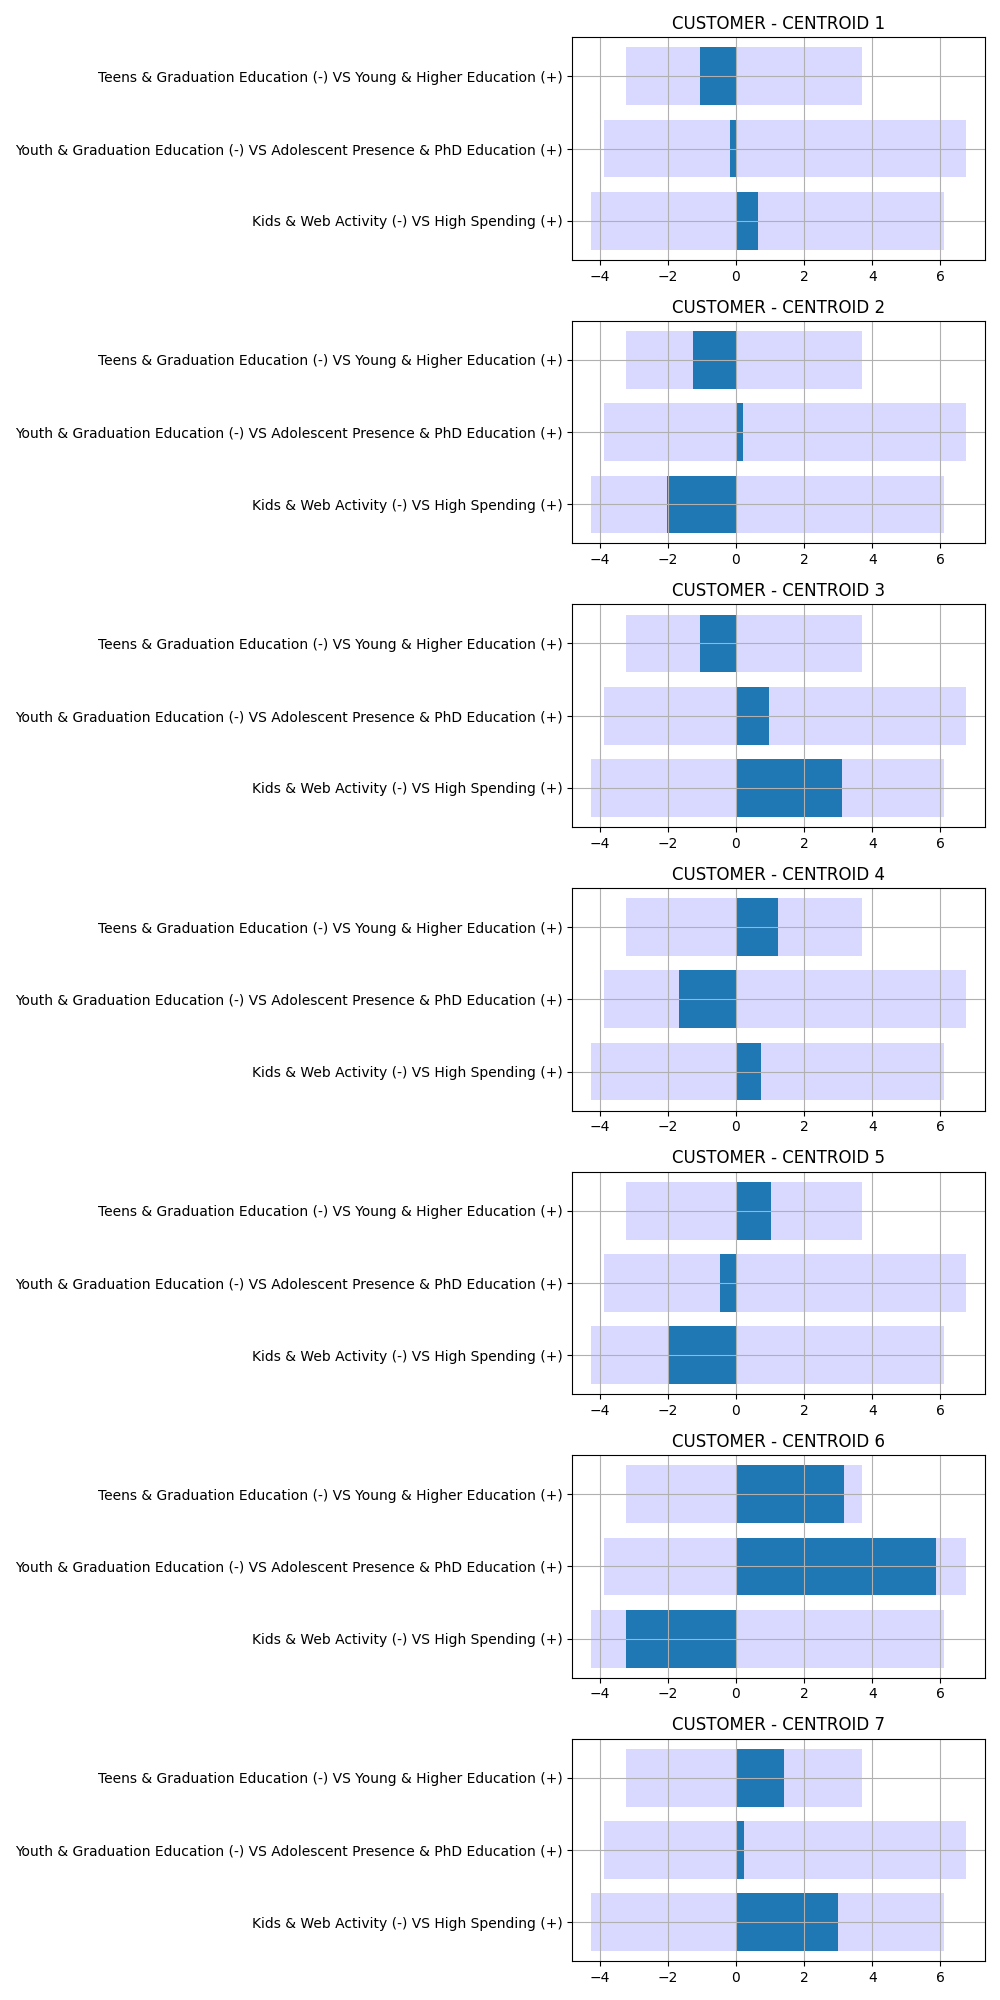

In [133]:
# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y = Yworkdf_std.max(axis=0)
mins_y = Yworkdf_std.min(axis=0)

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(7, 1, figsize=(10, 20))
for ii in range(k_std):
    ax_centroids[ii].barh(np.arange(km_std.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].barh(np.arange(km_std.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].barh(np.arange(km_std.cluster_centers_.shape[1]), km_std.cluster_centers_[ii, :])
    ax_centroids[ii].set_yticks(ticks=np.arange(km_std.cluster_centers_.shape[1]))
    ax_centroids[ii].set_yticklabels(labels=pc_names_std)
    ax_centroids[ii].grid(visible=True, which='both')
    ax_centroids[ii].set_yticklabels(labels=pc_names_std, rotation=0, ha='right')
    plt.tight_layout()
    ax_centroids[ii].set_title(f'CUSTOMER - CENTROID {ii+1}')
plt.show()


In [ ]:
cluster_names_std = ['Other',
                     'Premium Customer',
                     'Active Family Customer',
                     ]

In [ ]:
# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y = Yworkdf_mm.max(axis=0) 
mins_y = Yworkdf_mm.min(axis=0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(3,1, figsize=(5, 14))
for ii in range(k_mm):
    ax_centroids[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), km_mm.cluster_centers_[ii,:])
    ax_centroids[ii].set_xticks(ticks=np.arange(km_mm.cluster_centers_.shape[1]))
    ax_centroids[ii].set_xticklabels(labels=pc_names_mm)
    ax_centroids[ii].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ii].set_title(f'CUSTOMER - CENTROID {ii+1}')

In [ ]:
cluster_names_mm = ['Family Customer',
                    'Single Customer',
                    'Active Customer',
                    ]

## 7 - Clusters and Centroid Evaluation
- For both the DFs, perform an internal and an external evaluation of the clusterings obtained
  - Measure the silhouette scores of the clusters (internal evaluation);
  - perform an external evaluation of the clusters analyzing and plotting the distribution of the labels (view lesson 22/12/23)
  - Comment the results. Compare the results obtained from Xworkdf std and Xworkdf mm and comment them

In [ ]:
silscores = silhouette_samples(Yworkdf_std, km_std.labels_)
cluster_silscores = [np.mean (silscores [km_std.labels_ == kk]) for kk in range (k_std) ]
display(pd.DataFrame(np.array(cluster_silscores + [np.max(silcoeff_list_std)]), index=cluster_names_std + ['Global'], columns=['Sil. Score' ]))

In [ ]:
silscores = silhouette_samples(Yworkdf_mm, km_mm.labels_)
cluster_silscores = [np.mean (silscores [km_mm.labels_ == kk]) for kk in range (k_mm) ]
display(pd.DataFrame(np.array(cluster_silscores + [np.max(silcoeff_list_mm)]), index=cluster_names_mm + ['Global'], columns=['Sil. Score' ]))

In [ ]:
#EXTERNAL EVALUATION ????